# I&E Study 7.1 Automated Stakeholder Analysis for Hedera


In this Notebook we will demonstrate how to scrape, clean, analyse and visualise data from different resources to do stakeholder analysis for Hedera.

## Scraping

First we will gather data from the website https://seepnetwork.org. More specifically we will collect the data of the members of the seepnetwork.

For this we will define a method that will do the download, or if we already have the file in our local folder we just load it from there to reduce network traffic towards there website.

In [1]:
import requests
import os
from pathlib import Path

def load_page(name, path):
    
    displayname = name.replace('https://', '')
    full_path = path+displayname
    
    content = ""
    
    try:
        with open(full_path, 'r', encoding='utf-8') as f:
            content = f.read().replace("\n", "").replace("\t", "")
    except (OSError, IOError) as e:
        response = requests.get(name)
        directory = os.path.dirname(full_path)
        Path(directory).mkdir(parents=True, exist_ok=True)
        open(full_path, 'wb').write(response.content)
        content = response.content
        
    return content 


First we will scrape the main page.

In [2]:
file_dir = "webpages/"
parent_page = "https://seepnetwork.org"
main_content = load_page(parent_page + "/Profiles", file_dir)

Next we will get all of the links to the individual member profile pages. Therefor we select all of the elements and extract the href field.

In [3]:
from bs4 import BeautifulSoup

bs = BeautifulSoup(main_content)

sub_links = []
for link in bs.select(".mapListViewItem .button.border.blue a"):
    sub_links.append(link["href"])
    
print(len(sub_links))

94


^ Number of memebers found.

To get the members data we download the profile pages and parse the needed fields into an array for further processing.

In [4]:
import pandas as pd

data = []

for link in sub_links:
    content = load_page(parent_page+link, file_dir)
    bs = BeautifulSoup(content)
    parts = bs.select(".sidebar.left")
    
    name = parts[0].select_one("h3").string.strip()
#     years_of_membership = parts[0].select_one(".sidebarRight > p").string[0]
    location = parts[0].select_one(".sidebarRight .twoColLeft > p").contents[-1].strip()
    website = parts[0].select_one(".sidebarRight .twoColRight a")['href'].strip()
    org_type = parts[0].select_one(".sidebarRight .twoColRight > p").contents[-1].strip()
    mission_statement = parts[1].select(".sidebarRight > p")[0].contents[-1].strip()
    countries_of_involvement = parts[1].select(".sidebarRight > p")[1].contents[-1].strip()
    practice_areas = parts[1].select(".sidebarRight > p")[2].contents[-1].strip()
    
    data.append([name, location, website, org_type, mission_statement, countries_of_involvement, practice_areas])

In [5]:
data[:10]

[['Access to Finance Rwanda',
  'Rwanda',
  'http://www.afr.rw/',
  'Development Organization',
  'Low income Rwandans, especially women and youth, benefit from use of a variety of appropriate financial services',
  'Rwanda',
  'Fragile & Conflict-affected Environments, Gender Equality, Health, Housing'],
 ['AEMFI - Association of Ethiopian Microfinance Institutions',
  'Ethiopia',
  'http://www.aemfi-ethiopia.org/',
  'National, Regional, Global Network',
  'To enhance the capacity of microfinance institutions and financial cooperatives to deliver financials services to urban and rural households through technical assistance, human capital development, knowledge management, research, networking and advocating and promoting the industry with mutual cooperation from its members, practitioners and key stakeholders.',
  'Ethiopia',
  'Education; Environment & Climate; Financial Consumer Protection; Financial Inclusion; Housing; Livelihoods; MSME Development; Rural & Agricultural Developme

Finally we write the parsed information into a csv file which can later be used as an input for the machine learning algorithms.

In [6]:
import csv
wtr = csv.writer(open ('member_data.csv', 'w', encoding='utf-8'), delimiter=',', lineterminator='\n')
for member in data :
    wtr.writerow (member)

## Analyzing the data


In [7]:
df = pd.read_csv('member_data.csv', header=None, names=["name", "location", "website", "org_type", "mission_statement", "countries_of_involvement", "practice_areas"])

In [8]:
pd.set_option('display.max_colwidth',200)
df.head(10)

,name,location,website,org_type,mission_statement,countries_of_involvement,practice_areas
0,Access to Finance Rwanda,Rwanda,http://www.afr.rw/,Development Organization,"Low income Rwandans, especially women and youth, benefit from use of a variety of appropriate financial services",Rwanda,"Fragile & Conflict-affected Environments, Gender Equality, Health, Housing"
1,AEMFI - Association of Ethiopian Microfinance Institutions,Ethiopia,http://www.aemfi-ethiopia.org/,"National, Regional, Global Network","To enhance the capacity of microfinance institutions and financial cooperatives to deliver financials services to urban and rural households through technical assistance, human capital development...",Ethiopia,Education; Environment & Climate; Financial Consumer Protection; Financial Inclusion; Housing; Livelihoods; MSME Development; Rural & Agricultural Development; Savings-Led Community Finance; Urban...
2,Aga Khan Foundation USA,United States,https://www.akfusa.org/,Development Organization,"Promote social development, primarily in low income countries.",Afghanistan; Bangladesh; India; Kenya; Kyrgyzstan; Madagascar; Mali; Mozambique; Pakistan; Tajikistan; Tanzania,"Education; Financial Consumer Protection; Food Security & Nutrition; Gender Equality; Rural & Agricultural Development; Urban Development; WASH (Water, Sanitation, & Hygiene); Youth & Children"
3,AMA - Afghanistan Microfinance Association,Afghanistan,http://www.ama.org.af/,"National, Regional, Global Network","To build an inclusive, sustainable and responsible development finance sector through policy advocacy, knowledge management, coordination & networking, and capacity building.",Afghanistan,Financial Inclusion
4,AMFA - Azerbaijan Micro-Finance Association,Azerbaijan,http://www.amfa.az/,"National, Regional, Global Network",To strengthen the capacity of micro-finance institutions and to promote effective collective action in advancing the interests of the micro-finance community and its clients.,Azerbaijan,Financial Consumer Protection; Financial Inclusion; Gender Equality; MSME Development
5,AMFI Kenya,Kenya,www.amfi-kenya.com,"National, Regional, Global Network","To champion the aspirations of microfinance institutions through advocacy, capacity building, linkages and research.",Kenya,"Financial Consumer Protection, Financial Inclusion, Housing, Livelihoods, Market Systems Development, MSME Development, Rural & Agricultural Development, Savings-Led Community Finance, WASH (Water..."
6,AMFIU - Association of Microfinance Institutions of Uganda,Uganda,http://www.amfiu.org.ug,"National, Regional, Global Network","To promote a professional, inclusive and responsive microfinance industry that contributes to transformation of livelihoods of Ugandans.",Uganda,Financial Consumer Protection; Financial Inclusion; Rural and Agricultural Development
7,AMIR - Association of Micro Finance Institutions in Rwanda,Rwanda,http://www.amir.org.rw,"National, Regional, Global Network",The mission of AMIR is to offer diversified services to microfinance institutions to enable them to work professionally and contribute to poverty reduction in a sustainable manner.,Rwanda,"Education, Financial Consumer Protection, Financial Inclusion, Savings-Led Community Finance"
8,APIM Madagascar - Association Professionnelle des Institutions de Microfinance,Madagascar,http://www.apimfmada.mg/,"National, Regional, Global Network",Favoriser l'inclusion financière ou l'accès aux services financiers; encourager la coopération entre les institutions de microfinance; assurer la représentation et la défense des intérêts collecti...,Madagascar,Education; Financial Consumer Protection; Financial Inclusion; Gender Equality; Livelihoods; Market Systems Development; MSME Development; Rural and Agricultural Development; Savings-led Community...
9,APSFD-BF - Association Professionnelle des Systèmes Financiers Décentralisés du Burkina Faso,Burkina Faso,http://www.apsfd-burkina.bf/,"National, Regional, Global Networ

In [9]:
# Load the regular expression library
import re
# Remove punctuation
df['text_processed'] = df["mission_statement"].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
df['text_processed'] = df['text_processed'].map(lambda x: x.lower())
# Print out the first rows of papers
df['text_processed'].head()


0                                                                                             low income rwandans especially women and youth benefit from use of a variety of appropriate financial services
1    to enhance the capacity of microfinance institutions and financial cooperatives to deliver financials services to urban and rural households through technical assistance human capital development ...
2                                                                                                                                               promote social development primarily in low income countries
3                                  to build an inclusive sustainable and responsible development finance sector through policy advocacy knowledge management coordination & networking and capacity building
4                              to strengthen the capacity of micro-finance institutions and to promote effective collective action in advancing the interests of the micro-finance c

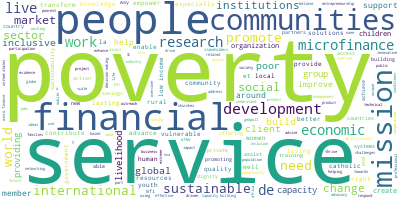

In [10]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(df['text_processed'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

['poverty', 'people', 'services', 'communities', 'financial', 'mission', 'development', 'economic', 'microfinance', 'research']


D:\soft\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


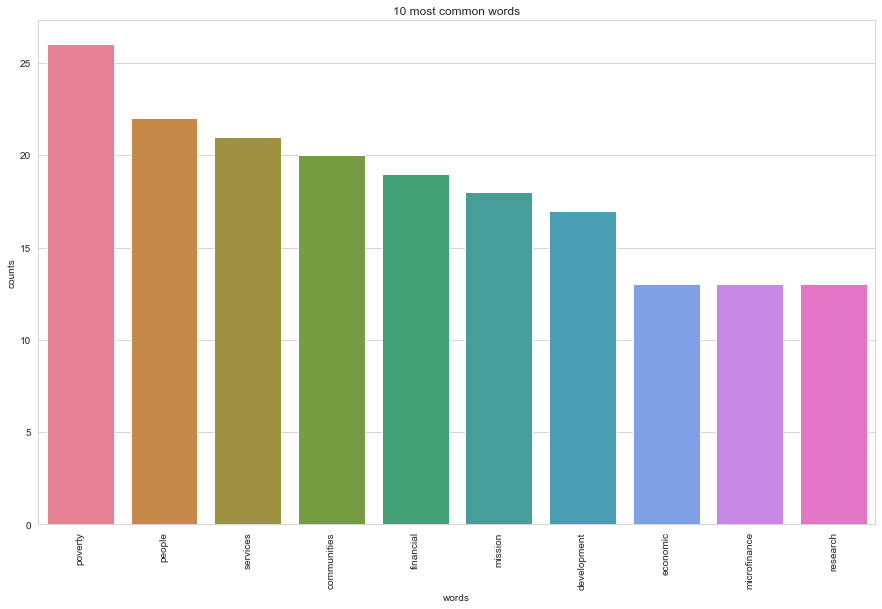

In [11]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    print(words)
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(df['text_processed'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)


In [12]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 5
number_words = 10
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
services financial capacity microfinance research people sector development income low

Topic #1:
poverty work communities clients economic people social inclusive women promote

Topic #2:
financial development services poverty communities institutions research market capacity sustainable

Topic #3:
people mission poverty international world development empower sustainable microfinance promote

Topic #4:
children world transform communities save organizations healthy water hope public


In [13]:
%%time
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis
# LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(number_topics))
LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)

Wall time: 2.83 s


In [ ]:
pyLDAvis.show(LDAvis_prepared)

D:\soft\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Note: if you're in the IPython notebook, pyLDAvis.show() is not the best command
      to use. Consider using pyLDAvis.display(), or pyLDAvis.enable_notebook().
      See more information at http://pyLDAvis.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8891/    [Ctrl-C to exit]


127.0.0.1 - - [17/Dec/2020 09:40:41] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [17/Dec/2020 09:40:41] "GET /LDAvis.css HTTP/1.1" 200 -
127.0.0.1 - - [17/Dec/2020 09:40:41] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [17/Dec/2020 09:40:41] "GET /LDAvis.js HTTP/1.1" 200 -
